# Modeling

To find the best model, firstly we will try to simplify our problem. In this notebook, different modeling techniques can be found. We will use different encoder, scaler , classifier and try different models. For simplfy to find best model, firstly we will merge functional and functional but needs repair target labels, and assign this to target. Then, we will assign non-functional to 0. First, we will try simple model then we will try to improve it. After finding the best model, we will try it for the multi-class label format. 

After decided to scaler and encoder, we tried DecisionTree Classifier, ExtraTreesClassifier and Random Forest. We found good results for Random Forest so we decided to do grid search to find best parameters. After we set this, we did feature importance to select best features and drop less important features. This can help us for future, when we want to do feature engineering. 

After looking the feature importance, we tried XGBoost, K-Nearest and LGBM Classifiers. And, lastly we decided our best model for binary target as Random Forest with grid search. It gave us the best scores. 

All details about results of these models can be found at the end of this notebook. Every details about models can be found in relative headings also.

In [52]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC
import gc; gc.enable()

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [53]:
df = pd.read_csv('clean_data.csv') #getting new clean dataframe

In [54]:
pd.options.display.max_columns=100 # to see all columns

In [55]:
# we dropped some columns for now, because we have categorized versions of them
df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

In [56]:
df1 = df.copy() # to protect original df , take the copy of it

In [57]:
df1.drop(columns=['lga','ward'],inplace=True ) #drop these columns for now

In [58]:
df1['permit'] = df1['permit'].astype(bool).astype(int) #changing from True/False to 0-1

In [59]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int) #changing from True/False to 0-1

Now, we need to use scaler for numeric columns and encoder for categorical columns. So, we divided columns in two.

In [60]:
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']

In [61]:
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [62]:
df1['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

0 = functional water points ,

1 = functional but needs repair water points,

2 = non-functinal water points

We collect functional and functional but needs help target together and make them 1, non-functional is 0.

In [63]:
# getting together labels and converting them 
target_status_group = {0:1, 1: 1, 2 : 0}
df1['status_group'] = df1['status_group'].replace(target_status_group)

In [64]:
df1['status_group'].value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

Now, 1 shows functional,

0 shows non-functional after here.

In [65]:
target='status_group' #assign out target column as target

# Making Pipeline / Baseline

In [15]:
# Dividing X and target 

used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [16]:
# to divide our X and y to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In this notebook, we will use train test split firstly to figure out the problem. After learning from the baseline, we will use cross validation technique to find the best result. Because, it is more convenient and easy to understand how is going on. For some models, we will use both of them to check our results are consistant or not. 
The metric for competition is balanced accuracy. But, to make sure and understand the progress, we want to check roc_auc score also especially for some models.

We will create empty dataframe to write our results on it to keep when parameters changed.

In [24]:
df_results = pd.DataFrame(columns=["Model", "Scaler",'Encoder',
                                   'roc_auc score mean', 'roc_auc score std']) # to see all results

## Baseline - Robust Scaler/ Target Encoder with LogReg

To scale numeric values and encode categorical columns, we will make pipeline and also use it in our model and classifier changes. For the first trial we use Robust Scaler as a scaler. Robust scales variables using statistics that are strong to outliers. Robust Scaler use IQR(Interquartile Range). As a encoder, we will try target encoder which works well with higher cardinality features. Our data has higher unique values also. 
Our first trial for baseline is Logistic Regression which predicts the probability that a certain instance belongs to a class. We chose balanced as class weight, because our classes have imbalanced. And also, solver is an algorithm to use in the optimization problem and for multiclass problems ‘lbfgs’ can handle multinomial loss. 

In [32]:
#making pipeline

scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])


# choosing model
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


Accuracy:
TRAIN: 0.7718855218855218
TEST: 0.7742424242424243

Balanced Accuracy:
TRAIN: 0.7514242992528544
TEST: 0.7529177387309345


For the first trial, this values can be chosen as baseline. We have already fine acceptable results for baseline. There is overfit but not much. For better understanding, we will plot confusion matrix.

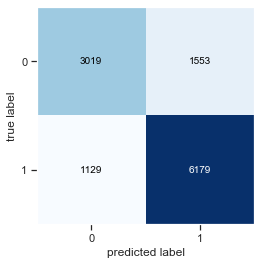

In [19]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

From the above matrix, we can make some interpretations. Such that, 1129 represents we predicted as non-functional but normally they are functional. And, 1553 shows that we predicted as functional, but normally they are non-functional.

Now, we will take the roc_auc score with doing LogReg with cross validation to compare other model results. We will take the mean of the scores, and standard deviation to understand better. We choose cv as 5, it gives 5 different results for each trial. We get and use mean of them. This application will give us more accurate results. Instead of train-test splits, we prefer cross validation which splitting train-test itself and do it for 5 times. It takes more time then train-test split so in some models, we will prefer train-test split again.

In [20]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.8313663919758361 +/- 0.0040017382683380015


We find better results than splitting even. And this result is better enough for baseline. Std is not too high also. These all results show us the importance of data cleaning. We tried to clean our data well. Maybe because of good cleaning we get good results for simple model.

In [25]:
df_results = df_results.append({       # first trial is written in results 
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'TargetEncoder',
               'roc_auc score mean' : 0.8313,
                    'roc_auc score std' : 0.0041}, ignore_index=True)


#  Robust Scaler/ WoE Encoder with LogReg

The weight of evidence encoder works as the predictive power of an independent variable accorfing to the dependent variable. It means that bad vs good. Basically, it is calculating the % of events and % of non-events. 

In [33]:
scaler = RobustScaler()
encoder = ce.WOEEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 


0.8317616620004907 +/- 0.0040460161388364115


It makes better than baseline. So, we will change our encoder to this one. 

In [26]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WeO',
                'roc_auc score mean' : 0.8318,
                    'roc_auc score std' : 0.0040}, ignore_index=True)


# Robust Scaler/ LeaveOneOut Encoder with LogReg

LeaveOneOut Encoder excludes the row’s target when calculating the mean target for a level to reduce the effect of outliers. It is good for outliers but we have already cleaned most of our outliers. To make sure, we tried this encoder also. 

In [39]:
scaler = RobustScaler()
encoder = ce.LeaveOneOutEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)


preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())



0.8312797087089017 +/- 0.004066043448636809


It did not better than WoE encoder. So, we will not change it. 

In [27]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'LeaveOneOut',
                'roc_auc score mean' : 0.8313,
                    'roc_auc score std' : 0.0041}, ignore_index=True)


# Robust Scaler/ OneHot Encoder with LogReg

In [41]:
scaler = RobustScaler()
encoder = ce.OneHotEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)


preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


0.8538287641042815 +/- 0.0024018659896273917
Accuracy:
TRAIN: 0.7922348484848485
TEST: 0.790993265993266

Balanced Accuracy:
TRAIN: 0.7773474554272171
TEST: 0.7753766770532994


Although one-hot encoder gives the best value, we choose our encoder as weight of evidence encoder. Because one-hot encoder creates a binary feature for each unique value in column. So, it is not very useful for high cardinality categorical values like our data. Because, it takes too much time to run the model each time. 

In [28]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'OneHot',
                'roc_auc score mean' : 0.8538,
                    'roc_auc score std' : 0.0024}, ignore_index=True)


# MinMax Scaler/ WoE Encoder with LogReg

When the distribution is not Gaussian or the standard deviation is very small, the min-max scaler generally works well. So, we will see and compare our scalers.

In [46]:
scaler = MinMaxScaler()
encoder = ce.WOEEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.831729064936378 +/- 0.0040065625540644


The result does not change significantly so, we decided our encoder as WoE and scaler as Robust.

In [29]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'MinMax' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8317,
                    'roc_auc score std' : 0.0040}, ignore_index=True)


# Comparing Different Encoder and Scalers

In [30]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std
0,LogReg,Robust,TargetEncoder,0.8313,0.0041
1,LogReg,Robust,WeO,0.8318,0.0040
2,LogReg,Robust,LeaveOneOut,0.8313,0.0041
3,LogReg,Robust,OneHot,0.8538,0.0024
4,LogReg,MinMax,WoE,0.8317,0.0040


For updated baseline, we choose WeO encoder with Robust scaler. Although, one hot encoder gave better results, it is not very suitable for our dataset which contains high unique numbers in columns.

# Decision Tree Classifier

From logistic regression, we have 0.83 roc-auc score. To improve this, we will try new models. First trial is Decision Tree Classifier. 

In [57]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                            random_state=42, class_weight='balanced')

pipe = make_pipeline(preprocessor,dt)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.786350564101643 +/- 0.008901914029896015


We tried decision tree with different parameters and found the best one and used it. 

In [35]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'DecisionTreeClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.7864,
                    'roc_auc score std' : 0.0089}, ignore_index=True)

# EkstraTreesClassifier

In [37]:
rf_extra = ExtraTreesClassifier(max_depth=5, criterion= 'entropy', min_samples_leaf=3, min_samples_split=18, 
                          random_state=42, n_estimators = 100, class_weight='balanced', n_jobs = -1)

pipe = make_pipeline(preprocessor,rf_extra)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8344599352882744 +/- 0.004585041521670182


Extra Trees works like a Random Forest. It builds multiple trees and splits nodes using random subsets of features. There are two main differences it does not samples without replacement, and nodes are split on random splits, not best splits. We also used different parameters and tuned them as best.

In [38]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'ExtraTreesClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8345,
                    'roc_auc score std' : 0.0045}, ignore_index=True)

This results are better than decision tree. It gives an idea about that we need to check Random Forest.

# RandomForestClassifier

Random forest models can reduce overfitting risk by randomness as building n_estimators, bootstrapping sample and 
splitting nodes on the best split among a random subset of the features selected at every node and converting non-homogeneous node into best possibles.

In [61]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,class_weight='balanced')

pipe = make_pipeline(preprocessor,rf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.919346222336363 +/- 0.0022277007468852186


In [42]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RandomForestClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9193,
                    'roc_auc score std' : 0.0022}, ignore_index=True)

We found good results with RandomForest classifier. We played around parameters and find these as a first trial. Now, with grid search we can find better results with tuning our parameters.

# Finding Best Parameters with Grid Search

Grid search shows us the best parameters for model. To understand this, we will do grid search. To run grid search with encoder and scaler as preprocessing takes too much time. So, we copied our dataframe and encoded categorical columns. Then, we used this encoded dataframe.

In [31]:
df2=df1.copy() #taking copy of dataframe

In [32]:
# encoding categorical columns and turn them to numeric version
encoder = WOEEncoder()

for c in cat_col:
    df2[str(c) + '_encoded'] = encoder.fit_transform(df2[c].values, df2[target])
    df2.drop(columns=c, inplace=True) 

In [33]:
# dividing our X and y and train-test splits

used_cols1 = [c for c in df2.columns.tolist() if c not in [target]]
X1=df2[used_cols1]
y1=df2[target]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [99]:
# setting grid search parameters and fit and run them
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2'],
          "min_samples_split": [2, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='

In [100]:
# to see the best score of grid search
grid_search.best_score_

0.9218773133232117

In [101]:
# to see the parameters for best score
grid_search.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 100}

We can find better parameters if we will give more parameters and values to grid search but it can takes hours or maybe our computer can not convert it. We have already run the code for 6 different parameters but during one hour it did not give results. So, we decided to set four parameters for run and we will use them.

In [102]:
# to set estimator 
best_rf = grid_search.best_estimator_

In [103]:
# to see the roc auc score with best parameters
scores = cross_val_score(best_rf, X1, y1, cv=5, scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())


0.9243196643217907 +/- 0.0023412211439206173


In [44]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RFC with GridSearch' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9243,
                    'roc_auc score std' : 0.0023}, ignore_index=True)

In [45]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std
0,LogReg,Robust,TargetEncoder,0.8313,0.0041
1,LogReg,Robust,WeO,0.8318,0.0040
2,LogReg,Robust,LeaveOneOut,0.8313,0.0041
3,LogReg,Robust,OneHot,0.8538,0.0024
4,LogReg,MinMax,WoE,0.8317,0.0040
5,DecisionTreeClassifier,Robust,WoE,0.7864,0.0089
6,ExtraTreesClassifier,Robust,WoE,0.8345,0.0045
7,RandomForestClassifier,Robust,WoE,0.9193,0.0022
8,RFC with GridSearch,Robust,WoE,0.9243,0.0023


# Feature Selection

We want to see importance of the features wirh random forest. First, fit train data then apply feature_importances_.

In [107]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Below code cell was taken from our instructor Bryan Arnold's notebook which is about classifiers. We changed the code according to our data and see the plot. 

Feature ranking:
1. feature 13 (0.147108)
2. feature 1 (0.143442)
3. feature 2 (0.141844)
4. feature 0 (0.072635)
5. feature 9 (0.068399)
6. feature 15 (0.062552)
7. feature 11 (0.050384)
8. feature 4 (0.050012)
9. feature 16 (0.034497)
10. feature 14 (0.033488)
11. feature 8 (0.032305)
12. feature 17 (0.031510)
13. feature 18 (0.030117)
14. feature 3 (0.026134)
15. feature 10 (0.025112)
16. feature 7 (0.018418)
17. feature 12 (0.015914)
18. feature 6 (0.009392)
19. feature 5 (0.006736)


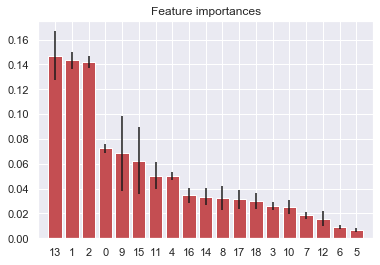

In [109]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()

According to below graph features 5-6 and 12 have less importance in our model where 13-1 and 2 have higher importance.
Now, we will drop last two features and try our model again.

In [46]:
# determination of discarding columns

discard = ['public_meeting', 'permit']

# to determine our X,y values again according to new dataframe
used_cols2 = [c for c in df2.columns.tolist() if c not in [target] + discard]
X2, y2 = df2[used_cols2], df2[target]

In [116]:
# setting classifier with best grid search parameters and taking roc-auc score

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                        criterion ='entropy',max_features = 'sqrt', min_samples_split = 10)

scores = cross_val_score(rf, X2, y2, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9241922995399895 +/- 0.0019821293437990617


In [47]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RFClassifier w/feature selection' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9242,
                    'roc_auc score std' : 0.0020}, ignore_index=True)

It gave nearly same results with whole dataset. It shows us that we can do feature engineering with playing around highly important columns in future.

# Finding Best Important Features of Categorical Columns

To make feature selection and engineering in future, we want to see importance of categorical columns. So, we dropped numeric columns and see our feature importance results again.

In [124]:
# define numeric columns
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [125]:
# dropping numeric columns
X1.drop(columns=num_col,inplace=True ) 

In [128]:
#splitting data as train and test and fitting to model
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Feature ranking:
1. feature 6 (0.223393)
2. feature 2 (0.108580)
3. feature 8 (0.089631)
4. feature 1 (0.081797)
5. feature 4 (0.079386)
6. feature 9 (0.073318)
7. feature 10 (0.068772)
8. feature 11 (0.065870)
9. feature 7 (0.064373)
10. feature 0 (0.058981)
11. feature 3 (0.054432)
12. feature 5 (0.031466)


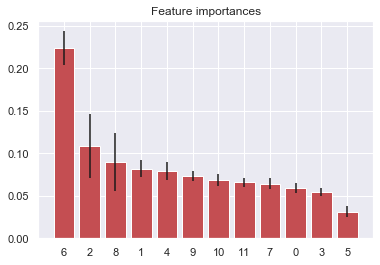

In [129]:
# looking importance again using Bryan Arnold's code from random forest lecture
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()

In between, categorical columns 6 has more importance then all others. It can give idea to us about feature engineering.

# XGBClassifier

XGBoost is an efficient and flexiable classifier which implements models with Gradient Boosting. Although, it is very usefull classifier, it can be overfit easily. So, parameter selection is very imporant for XGBoost. We can do grid search also for XGBoost to tune our parameters but it takes too much time. So, we played around our parameters manually and decided the best one. 

In [66]:
# to make sure we will use correct dataframe we will set our X , y again

used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

# to divide our X and y to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy:
TRAIN: 0.9380260942760943
TEST: 0.8617845117845118

Balanced Accuracy:
TRAIN: 0.9237369124184338
TEST: 0.8389350038141784


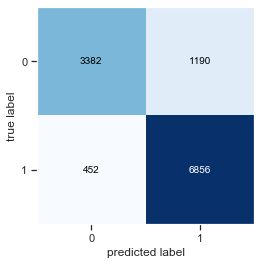

In [91]:
# choosing model

xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror',early_stopping_rounds=10,
                        eta = .1,max_depth = 12, colsample_bytree = .4, learning_rate = 0.1,
                        max_delta_step=1)

pipe = make_pipeline(preprocessor,xgb)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

The most important parameters are learning rate, early stopping round, max_depth and max_delta step for our tuning. When we changed them, results significantly changed. So, we set this parameters according to results which we find. To compare our results and make sure about roc-auc score, we run same model in cross validation.

In [85]:
pipe = make_pipeline(preprocessor,xgb)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8407004845846584 +/- 0.003506571678737707


In [92]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'XGBoost' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8407,
                    'roc_auc score std' : 0.0035}, ignore_index=True)

We found better results before, it is better than baseline but not better than Random Forest. So, we continue to try other models.

# k-Neigbours Classifier 

The general principle of k-Neighbors is to find closest in distance of the new point to predefined number of training points and predict the label according to this. First we tried this model without any parameter tuning. According to result, we will decide to tune or leave this model.

In [48]:
knn = KNeighborsClassifier()

pipe = make_pipeline(preprocessor,knn)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8852624439664136 +/- 0.0023672331839737193


In [100]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'K-Neigbours' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8852,
                    'roc_auc score std' : 0.0024}, ignore_index=True)

This is not better than our Random Forest model. So, we leave it also and do not work on tuning the parameters.

# LGBM Classifier

LGBM also constructs a gradient boosting model. It has some advantages that faster training speed and higher efficiency with lower memory usage. It is capable large data sets with significantly quicker than XGBoost. So, we will set this classifier and play with parameters.

Accuracy:
TRAIN: 0.8400673400673401
TEST: 0.830050505050505

Balanced Accuracy:
TRAIN: 0.8089504218513586
TEST: 0.797869555098716


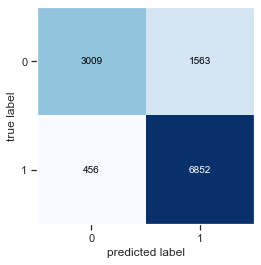

In [103]:
#seting model
lgbm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False,eta = .1,max_depth = 10, 
                      colsample_bytree = .4,learning_rate = 0.1,max_delta_step=1)

#sending everthing in pipe
pipe = make_pipeline(preprocessor,lgbm)
pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

With the setting the parameters , our model handled overfit problem easily in this model. But we had better results with Random Forest still. So, we will leave this model here. But, maybe later on for competition submission we can come back and tuned parameters again. Intuitively, we feel that to set LGBM Classifer is easier than XGBoost and it handles the overfit problem more easily. To make sure about our result, we did cross validation one more, and see roc-auc score.

In [104]:
pipe = make_pipeline(preprocessor,lgbm)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8973295998515114 +/- 0.002589344640728045


In [105]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LGBM' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8973,
                    'roc_auc score std' : 0.0025}, ignore_index=True)

# Comparing Results

In [106]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std
0,LogReg,Robust,TargetEncoder,0.8313,0.0041
1,LogReg,Robust,WeO,0.8318,0.0040
2,LogReg,Robust,LeaveOneOut,0.8313,0.0041
3,LogReg,Robust,OneHot,0.8538,0.0024
4,LogReg,MinMax,WoE,0.8317,0.0040
5,DecisionTreeClassifier,Robust,WoE,0.7864,0.0089
6,ExtraTreesClassifier,Robust,WoE,0.8345,0.0045
7,RandomForestClassifier,Robust,WoE,0.9193,0.0022
8,RFC with GridSearch,Robust,WoE,0.9243,0.0023
9,RFClassifier w/feature selection,Robust,WoE,0.9242,0.0020


According to our results dataframe, the better results for this binary problem is obtained with Random Forest Classifier with grid search. But some results need to play around it. We can do more parameter tuning and can find with LGBM or XGBoost maybe. But this is enough good for us for this step. Because the main problem is to build model with 3-class target. This all notebook gave idea us about what must be our steps for 3-class target. 

# Best Decided Model for Binary Target

Accuracy:
TRAIN: 0.9518728956228957
TEST: 0.8602693602693603

Balanced Accuracy:
TRAIN: 0.947773503869161
TEST: 0.8470385167371319


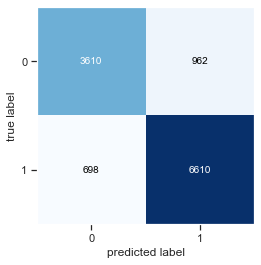

In [108]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                            criterion = 'entropy',max_features = 'sqrt',min_samples_split = 10)
 
pipe = make_pipeline(preprocessor,rf)
pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

After decided the model according to roc-auc scores. We looked our balanced accuracy for test set. Because the metric for competition is balanced accuracy. It is overfit, but still giving good test balanced accurancy results. So, we choose this model. LGBM is not over fit and giving near results to this model. These are two good models in this notebook. According to confusion matrix on test data, there is no exact split but it is shown that we will care about 962 points which is already predicted as functional but normally they are non-functional. Also, 698 points are predicted as non-functional but they are functional. With the learnings from binary model, we will continue to 3-class target model.